In [23]:
import kagglehub
import pandas as pd
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

# Download latest version
path = kagglehub.dataset_download("laotse/credit-risk-dataset")
csv_file = os.path.join(path, "credit_risk_dataset.csv") 
df = pd.read_csv(csv_file)

# Drop rows with missing values for analysis
df_cleaned = df.dropna()
df_cleaned.info()

# Count distinct values in each column
distinct_counts = df_cleaned.nunique()
for col in df_cleaned.columns:
    if distinct_counts[col] > 4:
        print(f"\nColumn '{col}' has {distinct_counts[col]} distinct values → needs grouping.")
    else:
        print(f"\nColumn '{col}' has {distinct_counts[col]} distinct values")

# Display distinct counts
print("\nDistinct values in each column:\n", distinct_counts)

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB

Column 'person_age' has 57 distinct

In [2]:
def filter_missing_values(df):
    # Separate rows with missing values for later use
    df_missing = df[df.isnull().any(axis=1)]

    
    # Check if the file already exists before saving missing values
    file_path = "filtered_missing_values.csv"
    if not os.path.exists(file_path):
        df_missing.to_csv(file_path, index=False)
        print(f"Missing values saved to {file_path}")
    else:
        print(f"{file_path} already exists, skipping save.")
    return df_missing


In [3]:
# Apply age grouping
df_cleaned["Age Group"] = pd.cut(df_cleaned["person_age"], bins=[0, 35, 50, float("inf")], labels=["Below 35", "36-50", "50+"])

numeric_columns = ["person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]
grouping_columns = ["Age Group"] + [f"{col} Group" for col in numeric_columns]

def numeric_classifier(df, numeric_columns):
    """Classifies numeric columns into groups based on median values and returns updated DataFrame and medians."""
    medians = {}
    
    for col in numeric_columns:
        median_value = df[col].median()
        medians[col] = median_value  # Store median value
        
        # Apply median-based grouping
        if col in ["loan_int_rate", "loan_percent_income"]:
            median_label = f"{median_value:.2f}"  # Show 2 decimal places
        else:
            median_label = f"{median_value:,.0f}"  # No decimals for other values
        
        df[f"{col} Group"] = df[col].apply(
            lambda x: f"Below or Equal to {median_label} (Median)" if x <= median_value else f"Above {median_label} (Median)"
        )
    
    return df, medians

def grouping(df):
    # Count defaults (1) and non-defaults (0) for each grouped parameter
    
    for col in grouping_columns:
        grouped_df = df.groupby([col, "loan_status"]).size().unstack(fill_value=0)
        grouped_df.columns = ["Non-Default (0)", "Default (1)"]
    
        # Rename index to match column name
        grouped_df.index.name = col.replace("_", " ").title()
    
        # Print formatted table
        print(tabulate(grouped_df, headers="keys", tablefmt="fancy_grid"))

df_cleaned, medians = numeric_classifier(df_cleaned, numeric_columns)        
grouping(df_cleaned)

╒═════════════╤═══════════════════╤═══════════════╕
│ Age Group   │   Non-Default (0) │   Default (1) │
╞═════════════╪═══════════════════╪═══════════════╡
│ Below 35    │             20038 │          5584 │
├─────────────┼───────────────────┼───────────────┤
│ 36-50       │              2209 │           554 │
├─────────────┼───────────────────┼───────────────┤
│ 50+         │               188 │            65 │
╘═════════════╧═══════════════════╧═══════════════╛
╒═══════════════════════════════════╤═══════════════════╤═══════════════╕
│ Person Income Group               │   Non-Default (0) │   Default (1) │
╞═══════════════════════════════════╪═══════════════════╪═══════════════╡
│ Above 55,956 (Median)             │             12434 │          1885 │
├───────────────────────────────────┼───────────────────┼───────────────┤
│ Below or Equal to 55,956 (Median) │             10001 │          4318 │
╘═══════════════════════════════════╧═══════════════════╧═══════════════╛
╒═════════════

C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\776643747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Age Group"] = pd.cut(df_cleaned["person_age"], bins=[0, 35, 50, float("inf")], labels=["Below 35", "36-50", "50+"])
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\776643747.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col} Group"] = df[col].apply(
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\776643747.py:21: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3623581920.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby([col, "loan_status"]).size().unstack(fill_value=0)


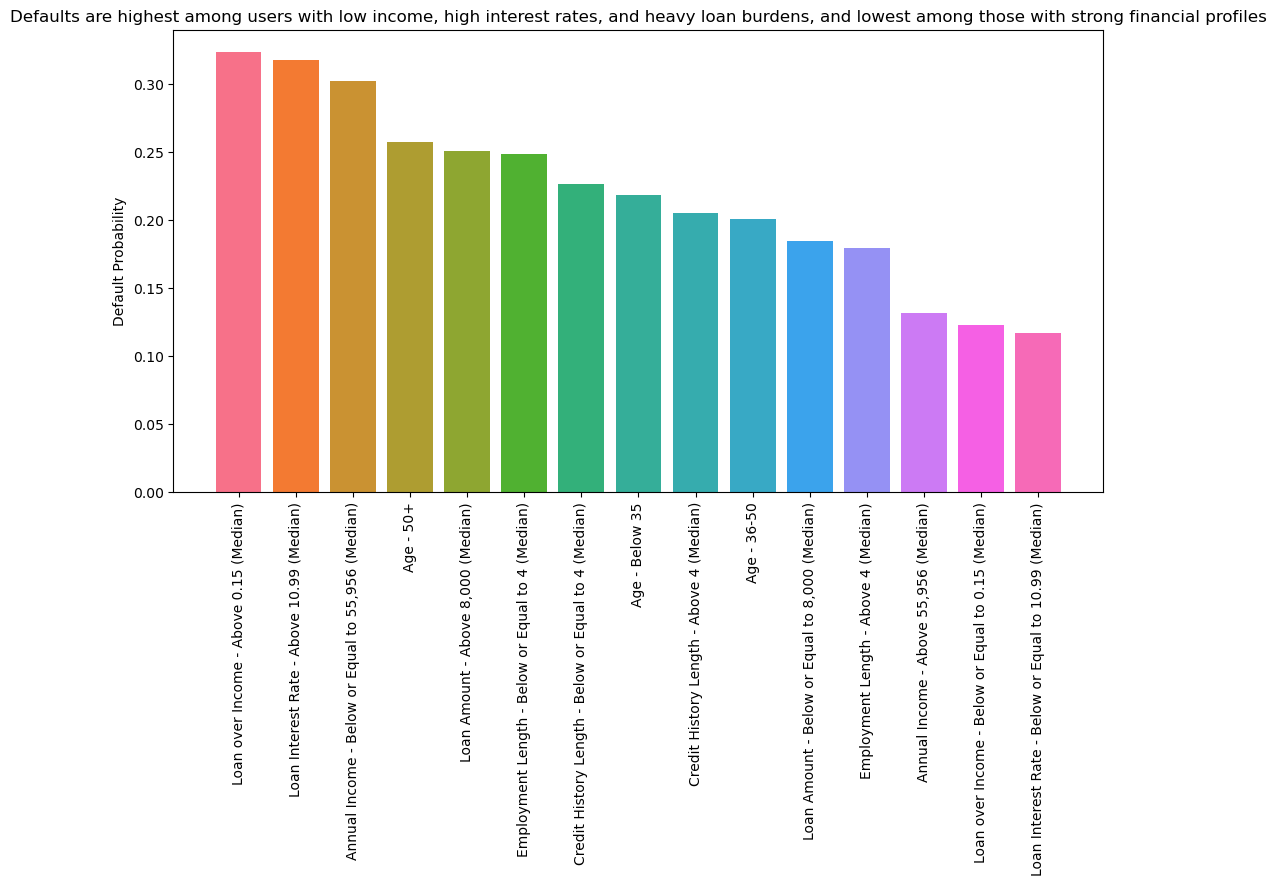


Default Probabilities:
{'Age - Below 35': 0.21793770978065724, 'Age - 36-50': 0.20050669562070214, 'Age - 50+': 0.25691699604743085, 'Annual Income - Above 55,956 (Median)': 0.13164327117815489, 'Annual Income - Below or Equal to 55,956 (Median)': 0.3015573713248132, 'Employment Length - Above 4 (Median)': 0.17921146953405018, 'Employment Length - Below or Equal to 4 (Median)': 0.24818035426731078, 'Loan Amount - Above 8,000 (Median)': 0.25064359267734554, 'Loan Amount - Below or Equal to 8,000 (Median)': 0.18411355261362086, 'Loan Interest Rate - Above 10.99 (Median)': 0.3172854235384939, 'Loan Interest Rate - Below or Equal to 10.99 (Median)': 0.11689485023281673, 'Loan over Income - Above 0.15 (Median)': 0.32333457387420916, 'Loan over Income - Below or Equal to 0.15 (Median)': 0.12227849766493455, 'Credit History Length - Above 4 (Median)': 0.20520342777734887, 'Credit History Length - Below or Equal to 4 (Median)': 0.2260121134842206}


In [4]:
def plot_sorted_default_probabilities(df, grouping_columns, label_mapping):
    """Plots a sorted bar chart with distinct colors for each grouped parameter."""
    probabilities = {}

    # Compute default probabilities
    for col in grouping_columns:
        grouped_df = df.groupby([col, "loan_status"]).size().unstack(fill_value=0)
        grouped_df.columns = ["Non-Default (0)", "Default (1)"]
        grouped_df["Default Probability"] = grouped_df["Default (1)"] / (grouped_df["Non-Default (0)"] + grouped_df["Default (1)"])

        for category, probability in grouped_df["Default Probability"].items():
            label = f"{label_mapping.get(col, col)} - {category}"
            probabilities[label] = probability

    # Sort probabilities (descending order)
    sorted_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))

    # Generate distinct colors
    colors = sns.color_palette("husl", len(sorted_probs))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_probs.keys(), sorted_probs.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel("Default Probability")
    plt.title("Defaults are highest among users with low income, high interest rates, and heavy loan burdens, and lowest among those with strong financial profiles")
    plt.show()

    # Print results for report
    print(f"\nDefault Probabilities:")
    print(probabilities)

# Define custom labels for parameters
label_mapping = {
    "Age Group": "Age",
    "person_income Group": "Annual Income",
    "person_emp_length Group": "Employment Length",
    "loan_amnt Group": "Loan Amount",
    "loan_int_rate Group": "Loan Interest Rate",
    "loan_percent_income Group": "Loan over Income",
    "cb_person_cred_hist_length Group": "Credit History Length"
}

# Call function
plot_sorted_default_probabilities(df_cleaned, grouping_columns, label_mapping)


C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped.index, y=grouped.values, palette="viridis")


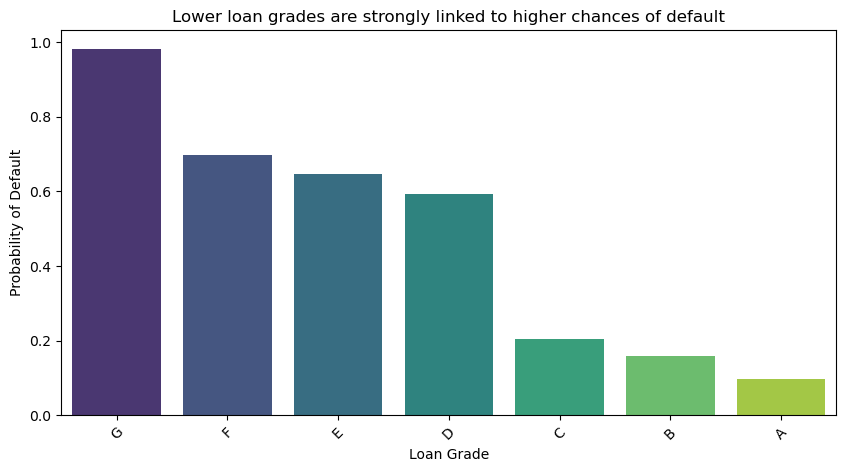


Default Probabilities for Lower loan grades are strongly linked to higher chances of default:
loan_grade
G    0.9831
F    0.6986
E    0.6460
D    0.5921
C    0.2030
B    0.1588
A    0.0961


C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['historical_default_label'] = df_cleaned['cb_person_default_on_file'].apply(lambda x: 'Yes' if x == 'Y' else 'No')
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped.index, y=grouped.values, palette="viridis")


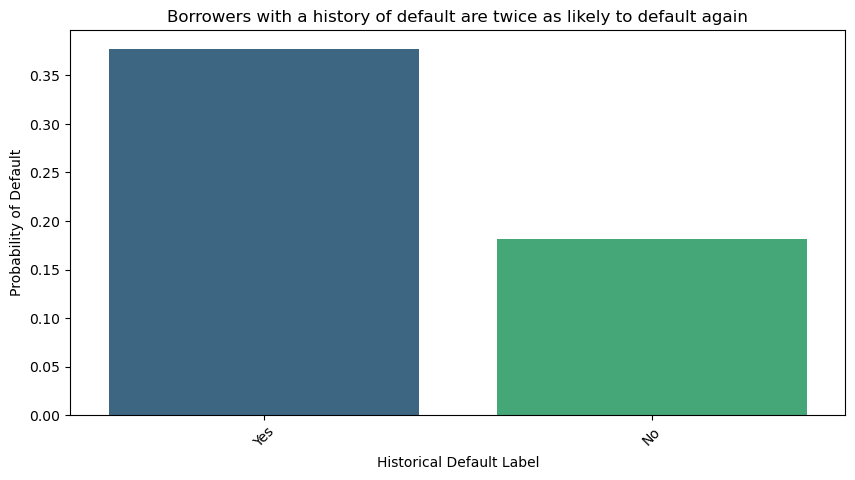


Default Probabilities for Borrowers with a history of default are twice as likely to default again:
historical_default_label
Yes    0.3776
No     0.1817


C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['credit_history_group'] = pd.cut(df_cleaned['cb_person_cred_hist_length'], bins=[0, 5, 10, 20, float('inf')], labels=["<5 Years", "5-10 Years", "10-20 Years", ">20 Years"])
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(col)['loan_status'].mean().sort_values(ascending=False)
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:27: FutureWarn

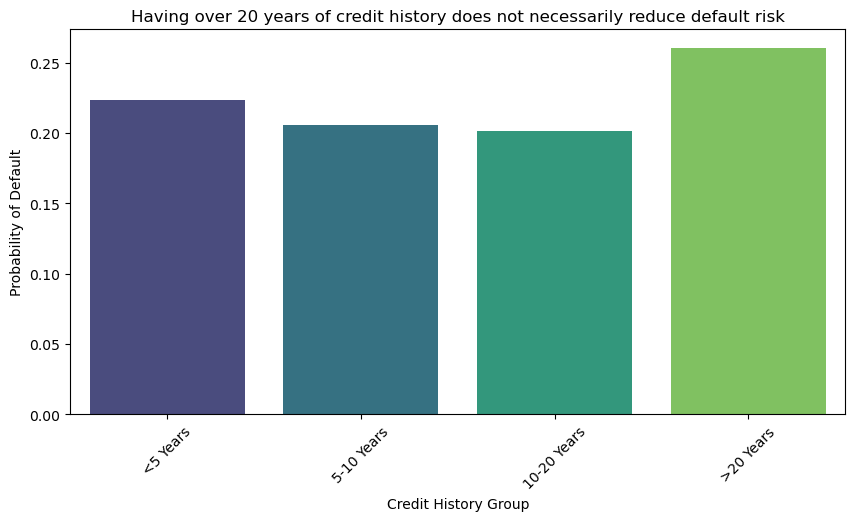

C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['loan_intent_label'] = df_cleaned['loan_intent'] + ' ($' + df_cleaned['loan_amnt'].astype(str) + ')'



Default Probabilities for Having over 20 years of credit history does not necessarily reduce default risk:
credit_history_group
>20 Years      0.2606
<5 Years       0.2237
5-10 Years     0.2058
10-20 Years    0.2018


C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped.index, y=grouped.values, palette="viridis")


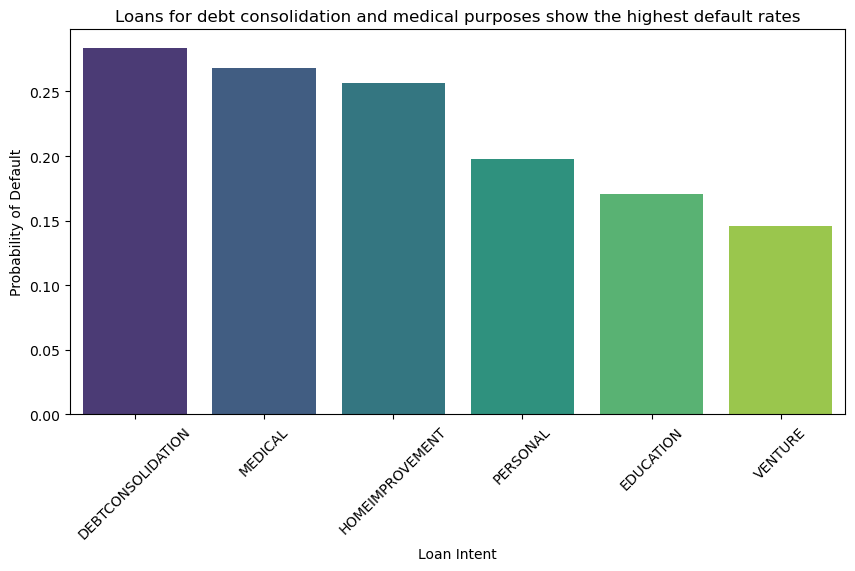


Default Probabilities for Loans for debt consolidation and medical purposes show the highest default rates:
loan_intent
DEBTCONSOLIDATION    0.2839
MEDICAL              0.2685
HOMEIMPROVEMENT      0.2567
PERSONAL             0.1975
EDUCATION            0.1702
VENTURE              0.1462


C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['age_group'] = pd.cut(df_cleaned['person_age'], bins=[0, 30, 40, 50, 60, float('inf')], labels=["<30", "30-40", "40-50", "50-60", "60+"])
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(col)['loan_status'].mean().sort_values(ascending=False)
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:27: FutureWarning: 

Passing `palette` without as

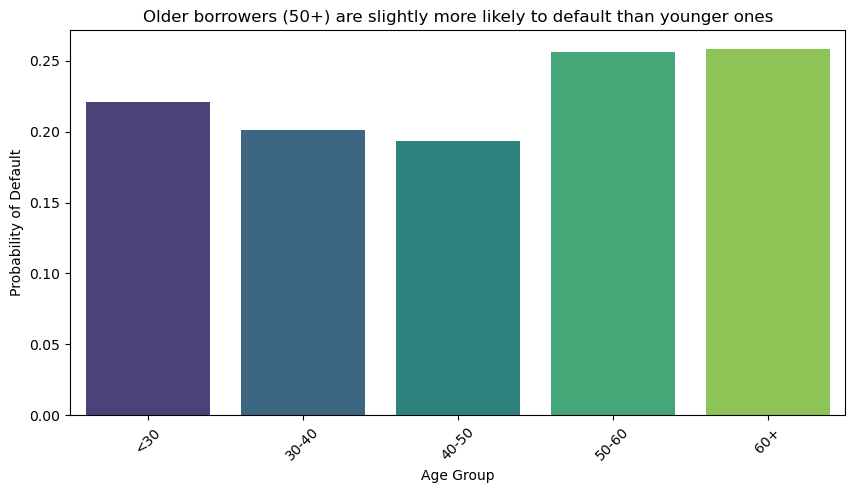


Default Probabilities for Older borrowers (50+) are slightly more likely to default than younger ones:
age_group
60+      0.2586
50-60    0.2564
<30      0.2211
30-40    0.2015
40-50    0.1933


C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['risky_loan'] = df_cleaned.apply(lambda row: 'Risky' if row['loan_int_rate'] > df_cleaned['loan_int_rate'].median() and row['loan_percent_income'] > df_cleaned['loan_percent_income'].median() else 'Not Risky', axis=1)
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped.index, y=grouped.values, palette="viridis")


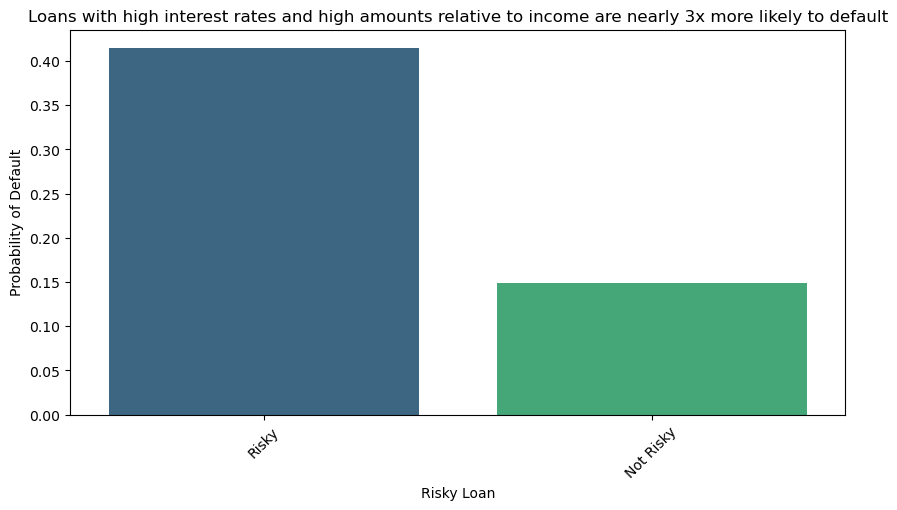


Default Probabilities for Loans with high interest rates and high amounts relative to income are nearly 3x more likely to default:
risky_loan
Risky        0.4147
Not Risky    0.1487


C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['borrower_profile'] = df_cleaned.apply(classify_borrower, axis=1)
C:\Users\thanh\AppData\Local\Temp\ipykernel_6276\3457503110.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped.index, y=grouped.values, palette="viridis")


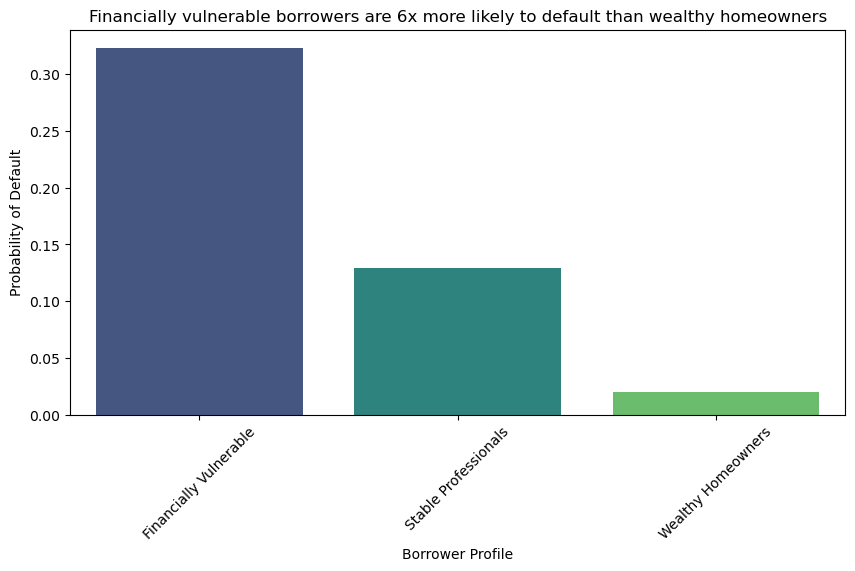


Default Probabilities for Financially vulnerable borrowers are 6x more likely to default than wealthy homeowners:
borrower_profile
Financially Vulnerable    0.3230
Stable Professionals      0.1287
Wealthy Homeowners        0.0195


In [5]:
def classify_borrower(row):
    if (
        row['person_income'] > income_median and
        row['person_home_ownership'] == 'OWN' and
        row['person_emp_length'] > emp_length_median
    ):
        return 'Wealthy Homeowners'
    elif (
        row['person_income'] > income_median and
        row['person_home_ownership'] != 'OWN' and
        row['person_emp_length'] > emp_length_median
    ):
        return 'Stable Professionals'
    elif (
        row['person_income'] <= income_median and
        row['person_home_ownership'] != 'OWN'
    ):
        return 'Financially Vulnerable'
    else:
        return 'Others'

def plot_default_probabilities(df, col, title):
    """Generates and displays a bar chart for default probabilities of a given categorical column."""
    grouped = df.groupby(col)['loan_status'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=grouped.index, y=grouped.values, palette="viridis")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel("Probability of Default")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    
    # Print results for report
    print(f"\nDefault Probabilities for {title}:")
    print(grouped.round(4).to_string())

# Question 1: Default probability by loan grade
plot_default_probabilities(df_cleaned, 'loan_grade', "Lower loan grades are strongly linked to higher chances of default")

# Question 2: Default probability based on historical defaults
df_cleaned['historical_default_label'] = df_cleaned['cb_person_default_on_file'].apply(lambda x: 'Yes' if x == 'Y' else 'No')
plot_default_probabilities(df_cleaned, 'historical_default_label', "Borrowers with a history of default are twice as likely to default again")

# Question 3: Default probability based on credit history length (grouped)
df_cleaned['credit_history_group'] = pd.cut(df_cleaned['cb_person_cred_hist_length'], bins=[0, 5, 10, 20, float('inf')], labels=["<5 Years", "5-10 Years", "10-20 Years", ">20 Years"])
plot_default_probabilities(df_cleaned, 'credit_history_group', "Having over 20 years of credit history does not necessarily reduce default risk")

# Question 4: Default probability by loan intent & amount
df_cleaned['loan_intent_label'] = df_cleaned['loan_intent'] + ' ($' + df_cleaned['loan_amnt'].astype(str) + ')'
plot_default_probabilities(df_cleaned, 'loan_intent', "Loans for debt consolidation and medical purposes show the highest default rates")

# Question 5: Default probability by age
df_cleaned['age_group'] = pd.cut(df_cleaned['person_age'], bins=[0, 30, 40, 50, 60, float('inf')], labels=["<30", "30-40", "40-50", "50-60", "60+"])
plot_default_probabilities(df_cleaned, 'age_group', "Older borrowers (50+) are slightly more likely to default than younger ones")

# Question 6: Risky loans - high interest & high loan-to-income ratio
df_cleaned['risky_loan'] = df_cleaned.apply(lambda row: 'Risky' if row['loan_int_rate'] > df_cleaned['loan_int_rate'].median() and row['loan_percent_income'] > df_cleaned['loan_percent_income'].median() else 'Not Risky', axis=1)
plot_default_probabilities(df_cleaned, 'risky_loan', "Loans with high interest rates and high amounts relative to income are nearly 3x more likely to default")

# Question 7: Wealthier people with home ownership & long employment length
income_median = df_cleaned['person_income'].median()
emp_length_median = df_cleaned['person_emp_length'].median()
df_cleaned['borrower_profile'] = df_cleaned.apply(classify_borrower, axis=1)

plot_default_probabilities(
    df_cleaned[df_cleaned['borrower_profile'] != 'Others'],  # optional: filter only 3 main groups
    'borrower_profile',
    "Financially vulnerable borrowers are 6x more likely to default than wealthy homeowners"
)

# Naive Bayes Prediction

In [7]:
def calculate_feature_probs(df_cleaned, feature_columns):
    feature_probs = {}
    df_default = df_cleaned[df_cleaned['loan_status'] == 1]
    df_non_default = df_cleaned[df_cleaned['loan_status'] == 0]

    for col in feature_columns:
        probs_default = df_default[col].value_counts(normalize=True).to_dict()
        probs_non_default = df_non_default[col].value_counts(normalize=True).to_dict()
        feature_probs[col] = {
            'default': probs_default,
            'non_default': probs_non_default
        }

    return feature_probs


In [9]:
def bayesian_predict(case, df_cleaned, feature_probs):
    prior_default_prob = df_cleaned['loan_status'].mean()

    likelihood_given_default = prior_default_prob
    likelihood_given_non_default = 1 - prior_default_prob

    for feature_name, feature_value in case.items():
        if feature_name in feature_probs:
            p_feature_given_default = feature_probs[feature_name]['default'].get(feature_value)
            p_feature_given_non_default = feature_probs[feature_name]['non_default'].get(feature_value)

            if p_feature_given_default is not None and p_feature_given_non_default is not None:
                likelihood_given_default *= p_feature_given_default
                likelihood_given_non_default *= p_feature_given_non_default
            else:
                # Skip feature if value is unseen in one of the classes
                continue

    evidence = likelihood_given_default + likelihood_given_non_default
    posterior_default = likelihood_given_default / evidence if evidence > 0 else 0

    # Plotting
    x = np.linspace(0, 1, 1000)
    prior_std = 0.05
    posterior_std = 0.05

    prior_dist = norm.pdf(x, prior_default_prob, prior_std)
    posterior_dist = norm.pdf(x, posterior_default, posterior_std)

    plt.figure(figsize=(10, 6))
    plt.plot(x, prior_dist, label='Prior', linestyle='--', color='blue')
    plt.plot(x, posterior_dist, label='Posterior', linestyle='-', color='red')
    plt.fill_between(x, 0, posterior_dist, color='red', alpha=0.3)
    plt.title(f"Given the profile, user has a {posterior_default * 100:.1f}% chance to default the loan.")
    plt.xlabel("Default Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return posterior_default


filtered_missing_values.csv already exists, skipping save.

Prediction for case 39:

User profile:
 person_age                                   23
person_income                             71500
person_home_ownership                      RENT
person_emp_length                           3.0
loan_intent                   DEBTCONSOLIDATION
loan_grade                                    D
loan_amnt                                 30000
loan_int_rate                               NaN
loan_status                                   1
loan_percent_income                        0.42
cb_person_default_on_file                     N
cb_person_cred_hist_length                    4
Name: 39, dtype: object


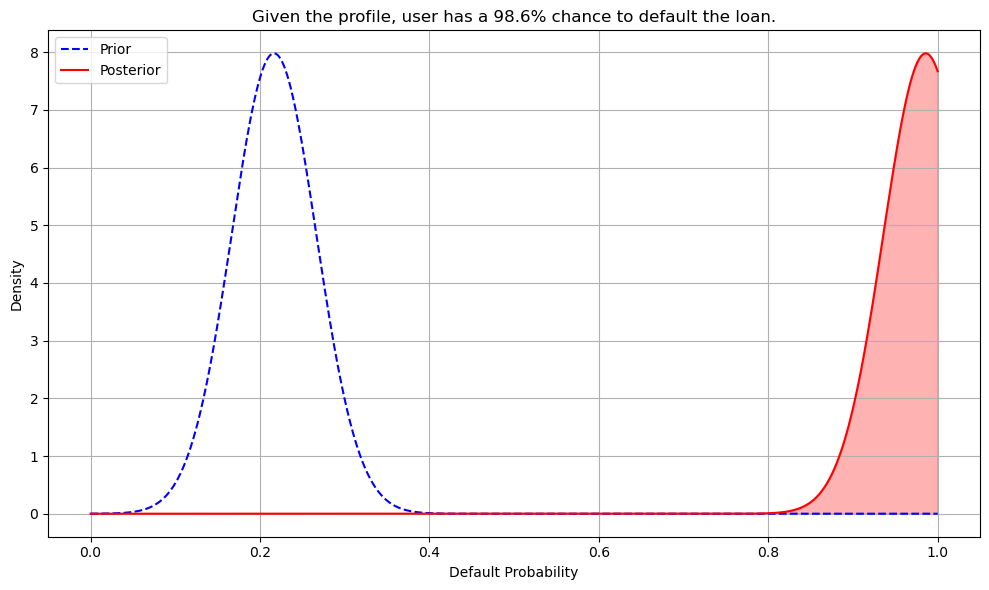


Prediction for case 50:

User profile:
 person_age                                   24
person_income                             78000
person_home_ownership                      RENT
person_emp_length                           4.0
loan_intent                   DEBTCONSOLIDATION
loan_grade                                    D
loan_amnt                                 30000
loan_int_rate                               NaN
loan_status                                   1
loan_percent_income                        0.38
cb_person_default_on_file                     Y
cb_person_cred_hist_length                    4
Name: 50, dtype: object


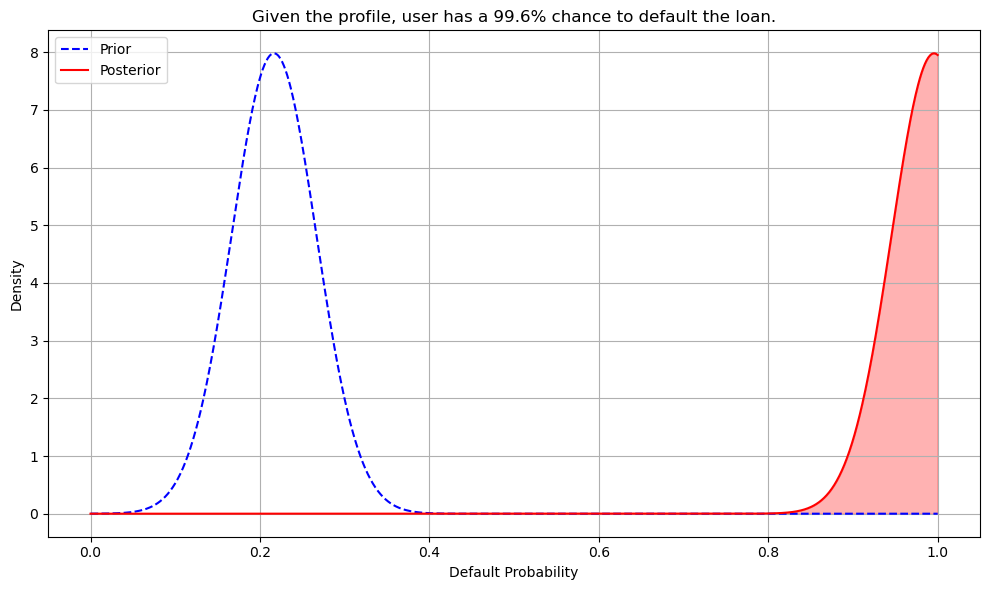


Prediction for case 57:

User profile:
 person_age                          23
person_income                   277000
person_home_ownership              OWN
person_emp_length                  3.0
loan_intent                   PERSONAL
loan_grade                           A
loan_amnt                        35000
loan_int_rate                      NaN
loan_status                          0
loan_percent_income               0.13
cb_person_default_on_file            N
cb_person_cred_hist_length           4
Name: 57, dtype: object


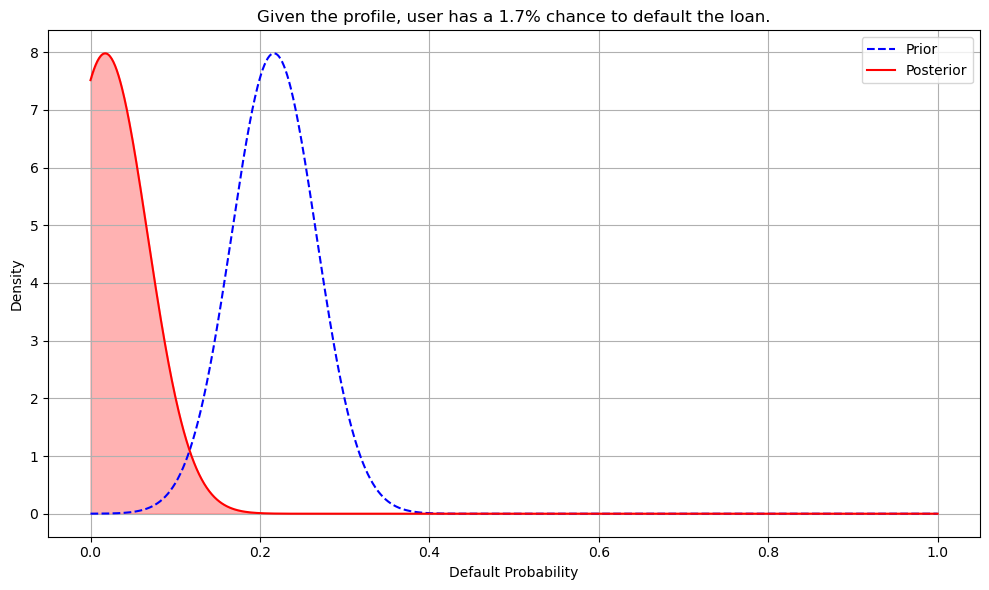


Prediction for case 59:

User profile:
 person_age                         24
person_income                   12000
person_home_ownership             OWN
person_emp_length                 2.0
loan_intent                   VENTURE
loan_grade                          E
loan_amnt                        1750
loan_int_rate                     NaN
loan_status                         0
loan_percent_income              0.15
cb_person_default_on_file           Y
cb_person_cred_hist_length          3
Name: 59, dtype: object


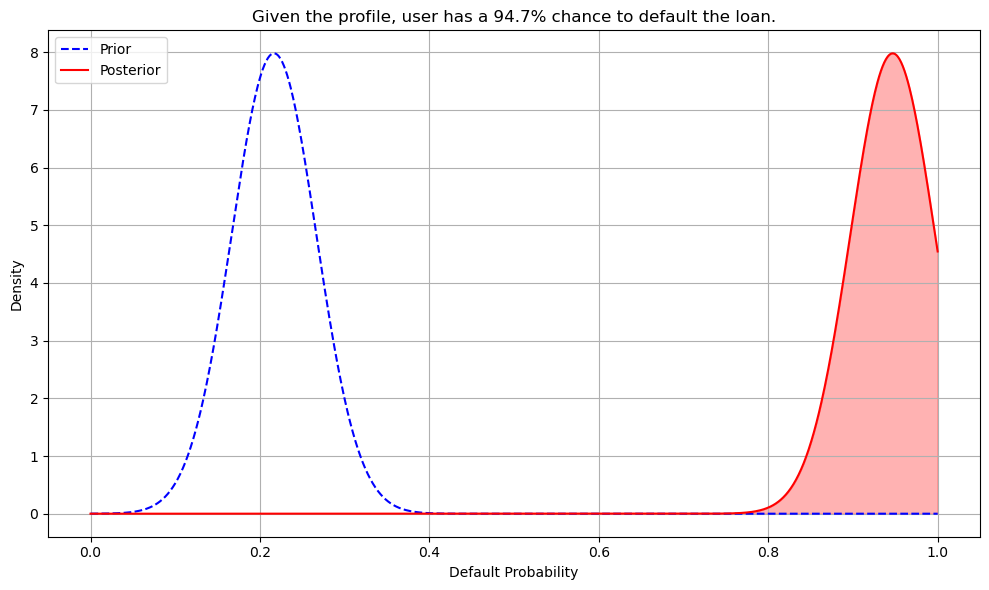


Prediction for case 62:

User profile:
 person_age                           26
person_income                    263000
person_home_ownership          MORTGAGE
person_emp_length                   0.0
loan_intent                   EDUCATION
loan_grade                            B
loan_amnt                         10000
loan_int_rate                       NaN
loan_status                           1
loan_percent_income                0.04
cb_person_default_on_file             N
cb_person_cred_hist_length            4
Name: 62, dtype: object


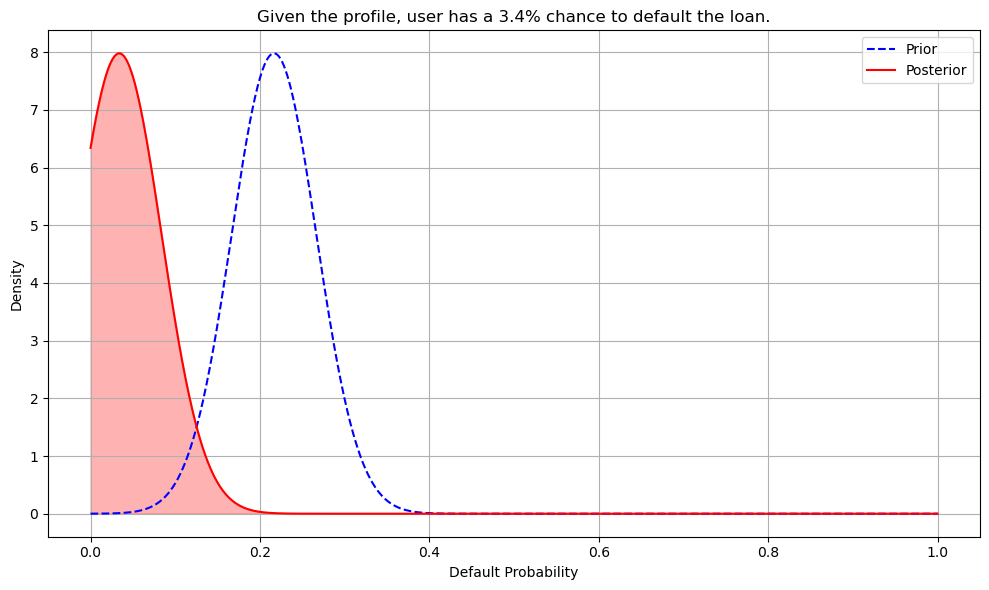


Prediction for case 70:

User profile:
 person_age                         25
person_income                   12000
person_home_ownership             OWN
person_emp_length                 0.0
loan_intent                   MEDICAL
loan_grade                          C
loan_amnt                        3000
loan_int_rate                     NaN
loan_status                         1
loan_percent_income              0.25
cb_person_default_on_file           N
cb_person_cred_hist_length          3
Name: 70, dtype: object


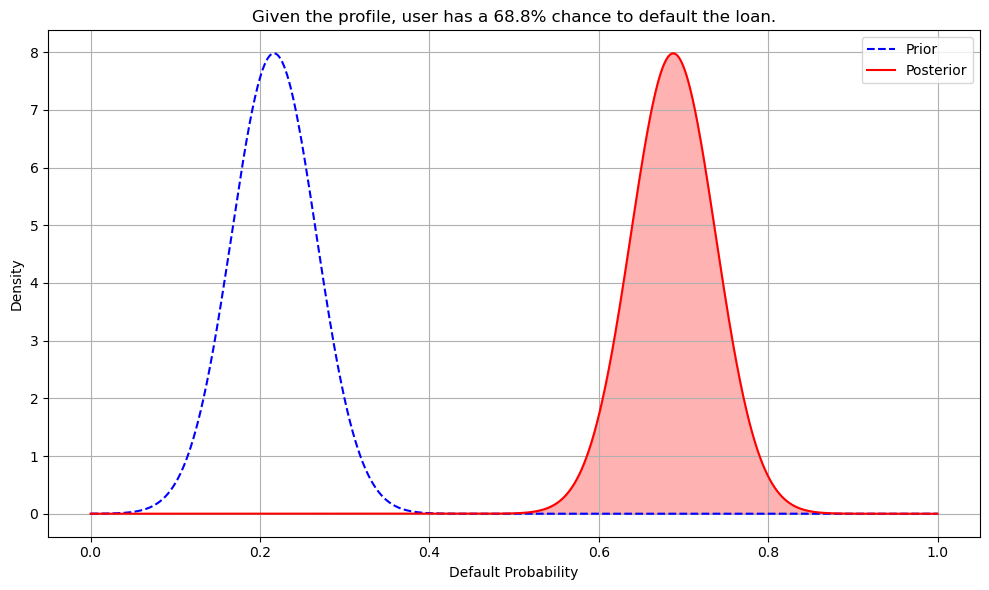


Prediction for case 71:

User profile:
 person_age                         22
person_income                   56950
person_home_ownership            RENT
person_emp_length                 6.0
loan_intent                   MEDICAL
loan_grade                          A
loan_amnt                       28000
loan_int_rate                     NaN
loan_status                         1
loan_percent_income              0.49
cb_person_default_on_file           N
cb_person_cred_hist_length          2
Name: 71, dtype: object


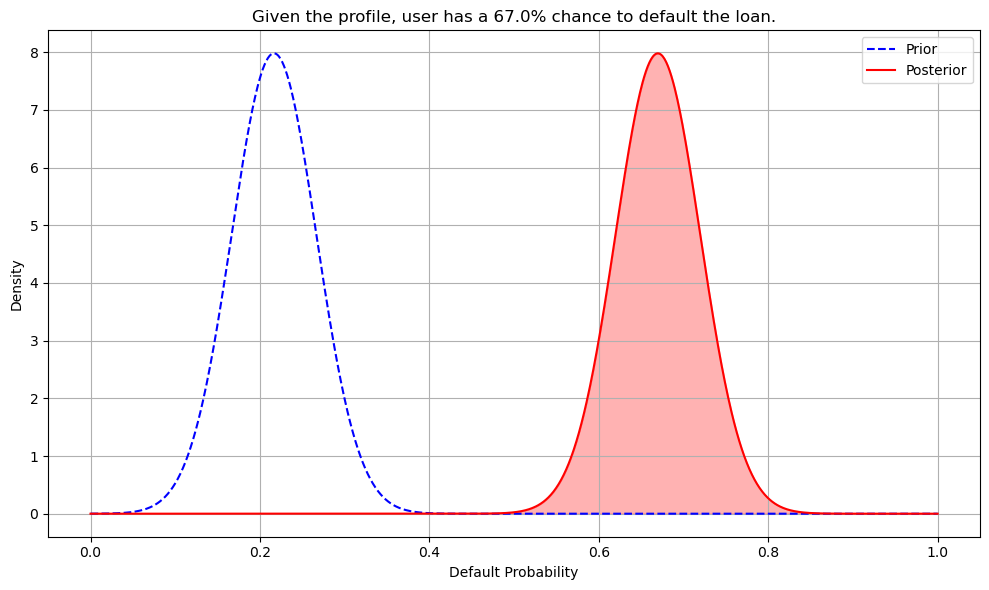


Prediction for case 84:

User profile:
 person_age                                   26
person_income                             12000
person_home_ownership                       OWN
person_emp_length                           0.0
loan_intent                   DEBTCONSOLIDATION
loan_grade                                    A
loan_amnt                                  2700
loan_int_rate                               NaN
loan_status                                   1
loan_percent_income                        0.23
cb_person_default_on_file                     N
cb_person_cred_hist_length                    4
Name: 84, dtype: object


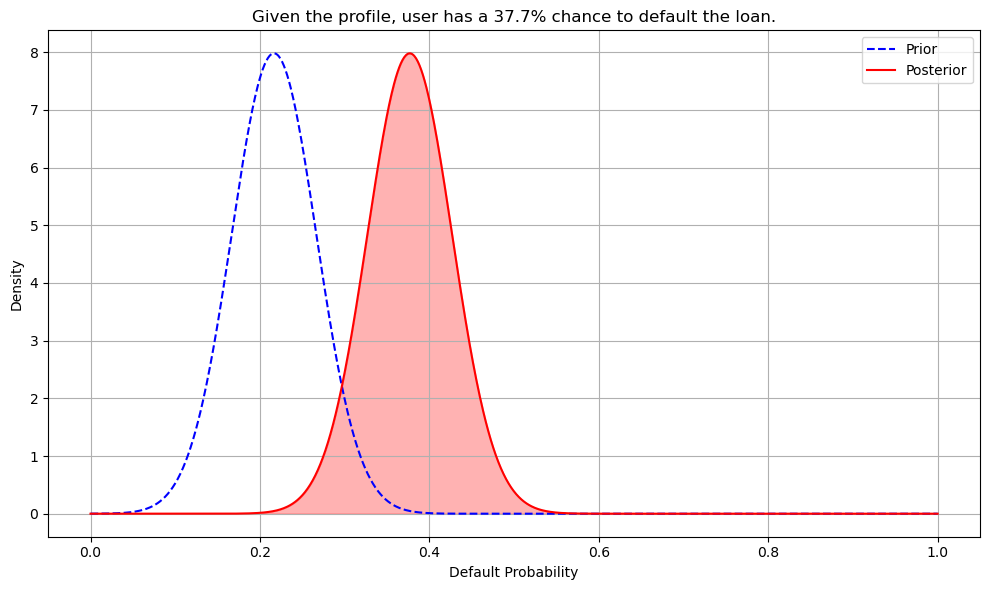


Prediction for case 85:

User profile:
 person_age                           22
person_income                    108000
person_home_ownership              RENT
person_emp_length                   6.0
loan_intent                   EDUCATION
loan_grade                            B
loan_amnt                         28000
loan_int_rate                       NaN
loan_status                           1
loan_percent_income                0.26
cb_person_default_on_file             N
cb_person_cred_hist_length            4
Name: 85, dtype: object


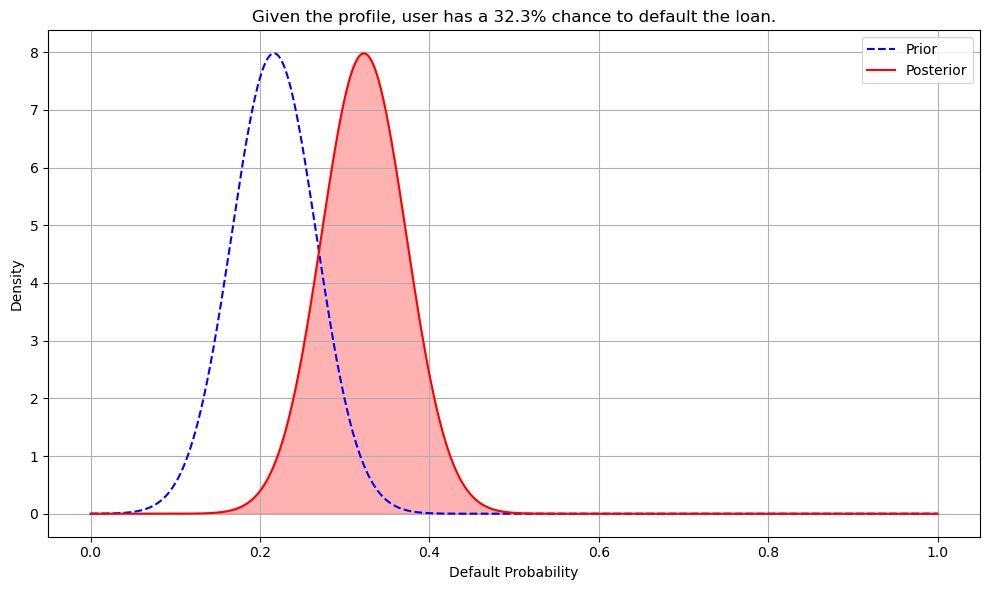


Prediction for case 87:

User profile:
 person_age                                 24
person_income                           69000
person_home_ownership                    RENT
person_emp_length                         2.0
loan_intent                   HOMEIMPROVEMENT
loan_grade                                  A
loan_amnt                               27600
loan_int_rate                             NaN
loan_status                                 1
loan_percent_income                       0.4
cb_person_default_on_file                   N
cb_person_cred_hist_length                  2
Name: 87, dtype: object


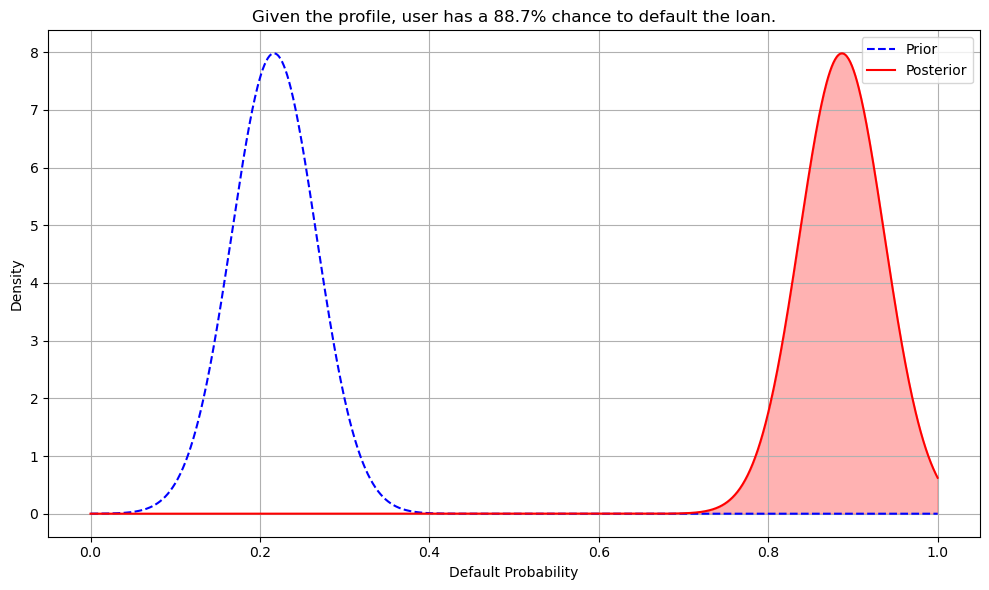


Prediction for case 90:

User profile:
 person_age                          22
person_income                   240000
person_home_ownership              OWN
person_emp_length                  6.0
loan_intent                   PERSONAL
loan_grade                           B
loan_amnt                        25000
loan_int_rate                      NaN
loan_status                          0
loan_percent_income                0.1
cb_person_default_on_file            N
cb_person_cred_hist_length           2
Name: 90, dtype: object


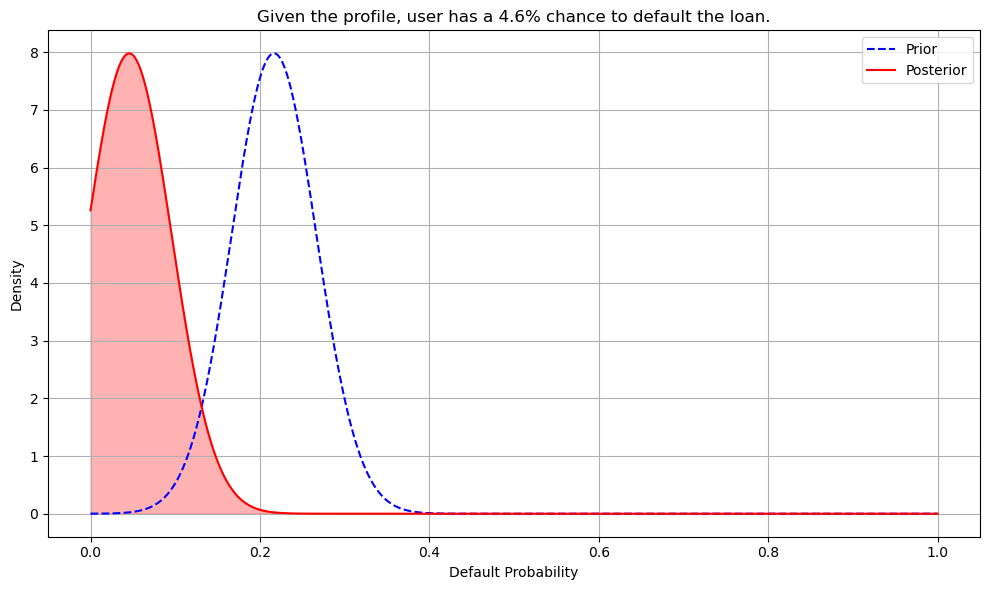


Prediction for case 93:

User profile:
 person_age                         24
person_income                   73399
person_home_ownership            RENT
person_emp_length                 0.0
loan_intent                   VENTURE
loan_grade                          D
loan_amnt                       27000
loan_int_rate                     NaN
loan_status                         1
loan_percent_income              0.37
cb_person_default_on_file           N
cb_person_cred_hist_length          3
Name: 93, dtype: object


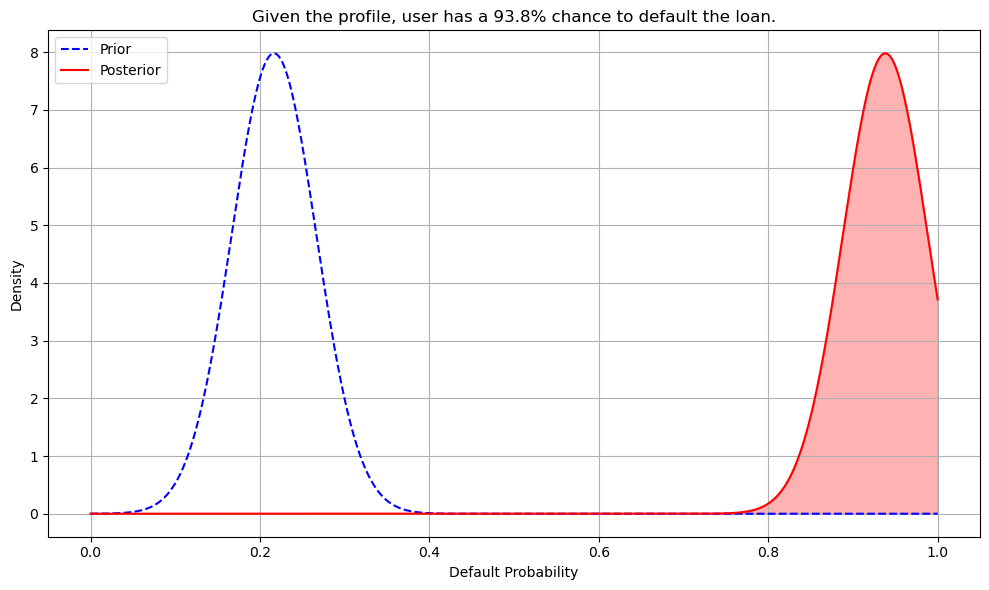


Prediction for case 105:

User profile:
 person_age                          22
person_income                    12600
person_home_ownership         MORTGAGE
person_emp_length                  NaN
loan_intent                   PERSONAL
loan_grade                           A
loan_amnt                         2000
loan_int_rate                     5.42
loan_status                          1
loan_percent_income               0.16
cb_person_default_on_file            N
cb_person_cred_hist_length           4
Name: 105, dtype: object


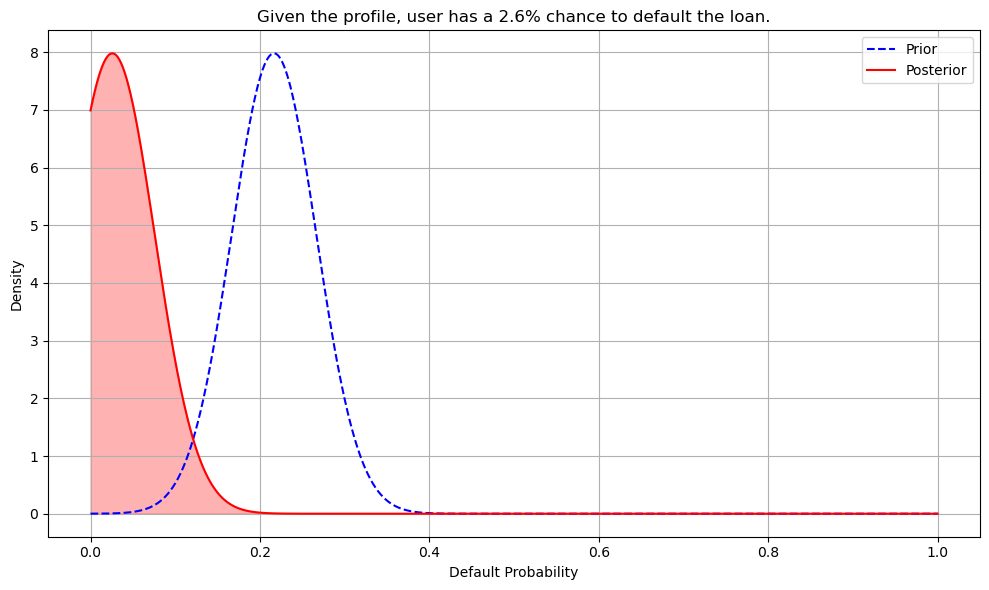


Prediction for case 108:

User profile:
 person_age                                 24
person_income                           41000
person_home_ownership                    RENT
person_emp_length                         2.0
loan_intent                   HOMEIMPROVEMENT
loan_grade                                  D
loan_amnt                               25000
loan_int_rate                             NaN
loan_status                                 1
loan_percent_income                      0.61
cb_person_default_on_file                   N
cb_person_cred_hist_length                  3
Name: 108, dtype: object


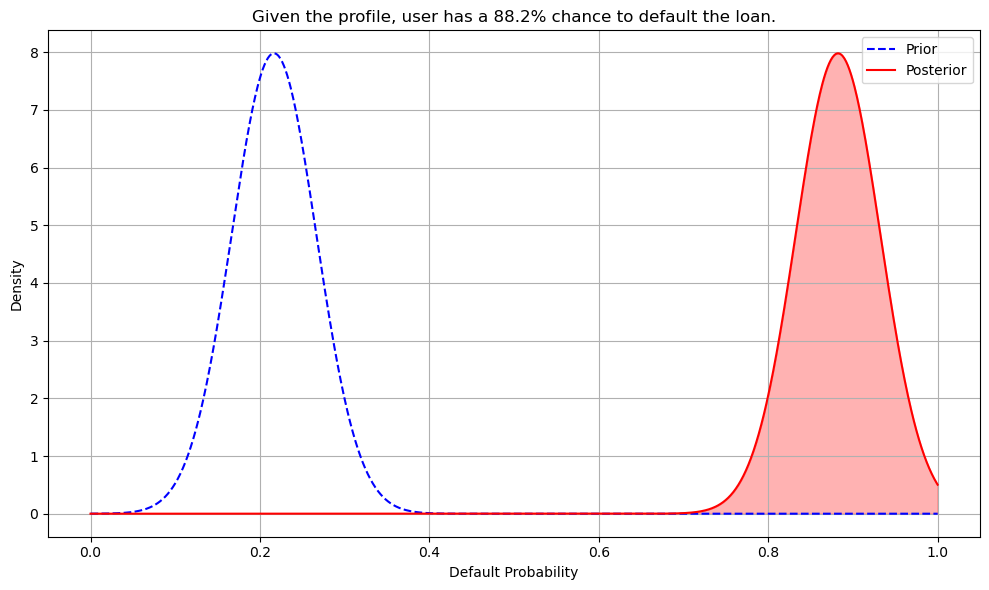


Prediction for case 114:

User profile:
 person_age                         24
person_income                  225000
person_home_ownership            RENT
person_emp_length                 0.0
loan_intent                   MEDICAL
loan_grade                          B
loan_amnt                        6000
loan_int_rate                     NaN
loan_status                         0
loan_percent_income              0.03
cb_person_default_on_file           N
cb_person_cred_hist_length          4
Name: 114, dtype: object


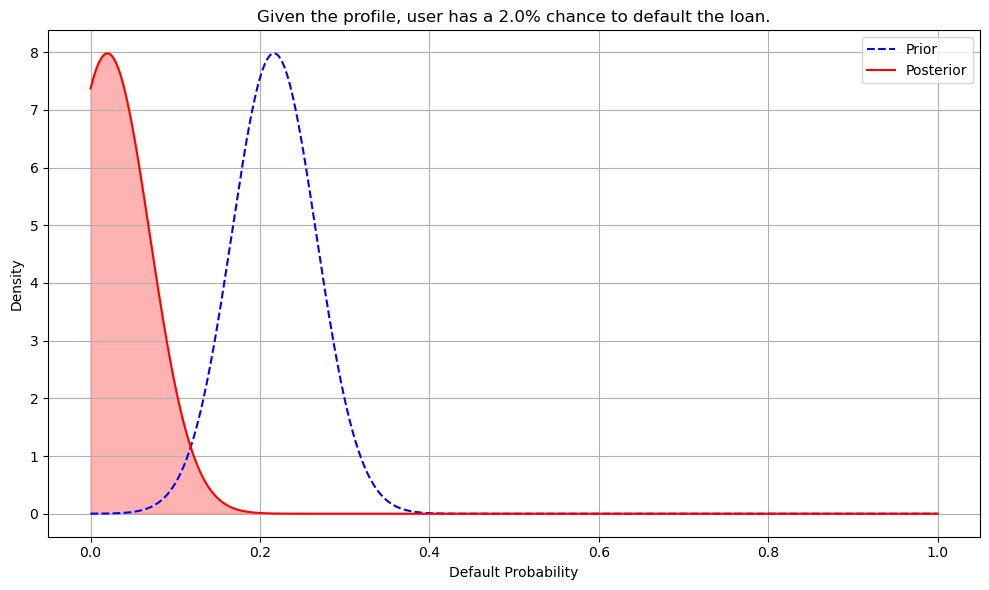


Prediction for case 120:

User profile:
 person_age                           22
person_income                     12996
person_home_ownership               OWN
person_emp_length                   1.0
loan_intent                   EDUCATION
loan_grade                            B
loan_amnt                          4750
loan_int_rate                       NaN
loan_status                           1
loan_percent_income                0.37
cb_person_default_on_file             N
cb_person_cred_hist_length            3
Name: 120, dtype: object


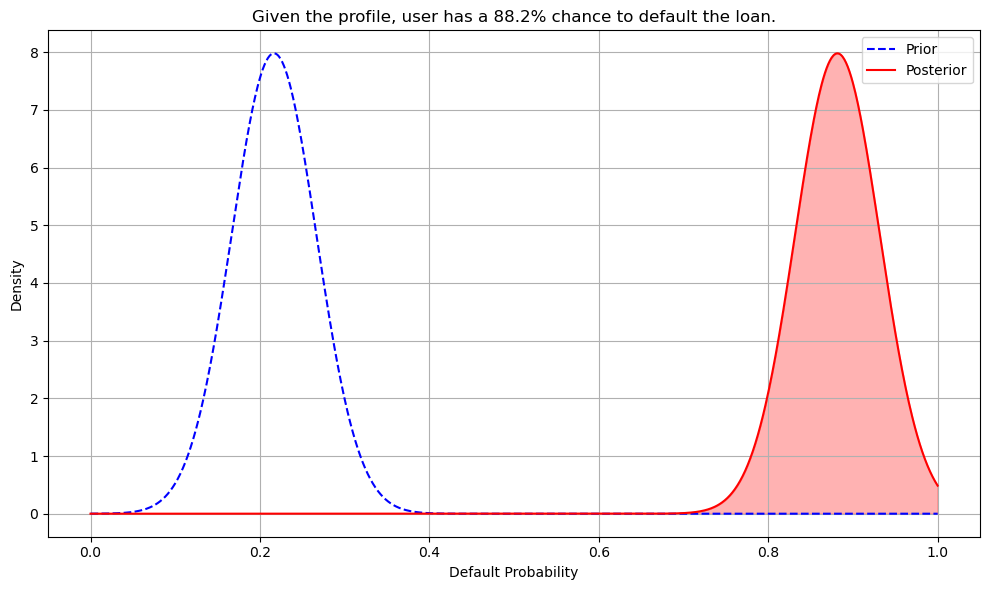


Prediction for case 152:

User profile:
 person_age                           22
person_income                     54996
person_home_ownership              RENT
person_emp_length                   6.0
loan_intent                   EDUCATION
loan_grade                            B
loan_amnt                         25000
loan_int_rate                       NaN
loan_status                           1
loan_percent_income                0.45
cb_person_default_on_file             N
cb_person_cred_hist_length            4
Name: 152, dtype: object


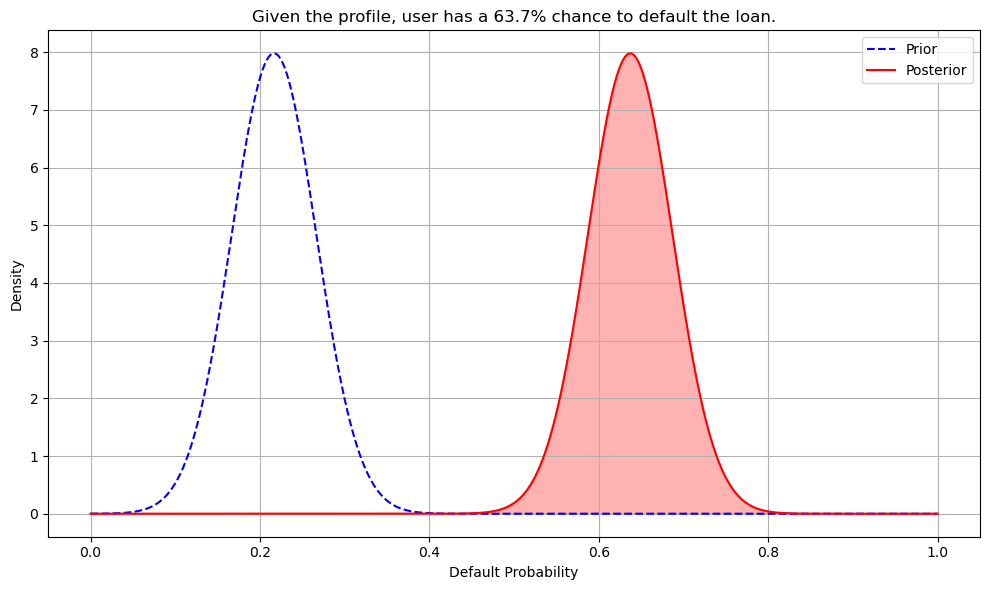


Prediction for case 153:

User profile:
 person_age                                 24
person_income                           55000
person_home_ownership                    RENT
person_emp_length                         4.0
loan_intent                   HOMEIMPROVEMENT
loan_grade                                  D
loan_amnt                               25000
loan_int_rate                             NaN
loan_status                                 1
loan_percent_income                      0.45
cb_person_default_on_file                   Y
cb_person_cred_hist_length                  4
Name: 153, dtype: object


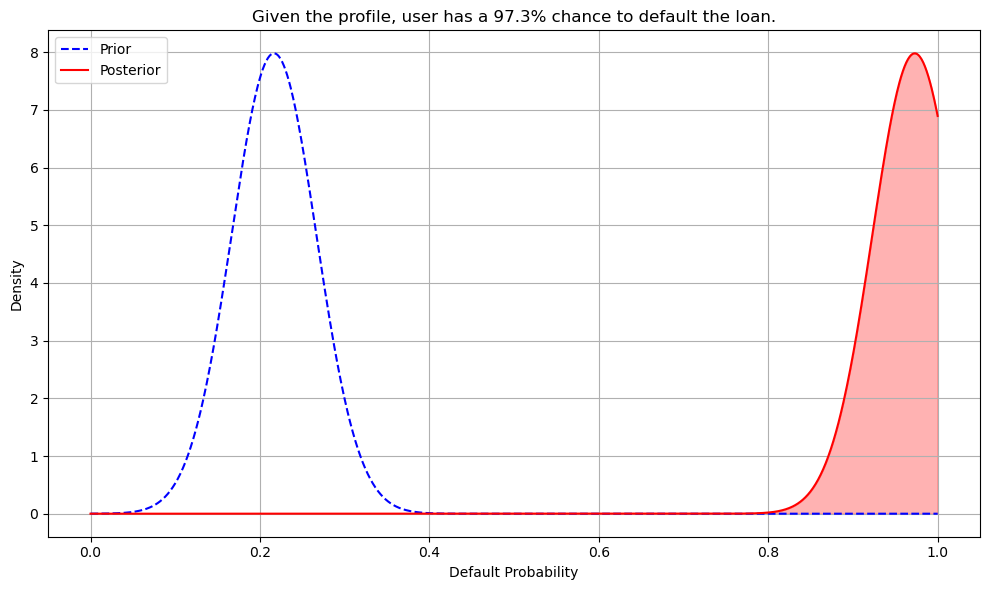


Prediction for case 164:

User profile:
 person_age                                   23
person_income                             14000
person_home_ownership                       OWN
person_emp_length                           2.0
loan_intent                   DEBTCONSOLIDATION
loan_grade                                    D
loan_amnt                                  4000
loan_int_rate                               NaN
loan_status                                   1
loan_percent_income                        0.29
cb_person_default_on_file                     N
cb_person_cred_hist_length                    3
Name: 164, dtype: object


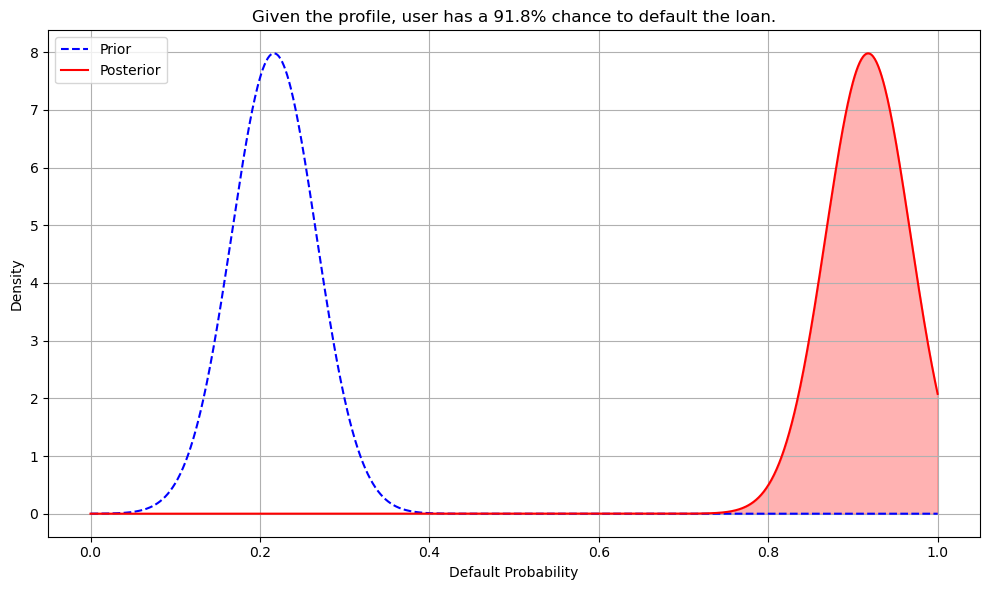


Prediction for case 174:

User profile:
 person_age                           23
person_income                    200000
person_home_ownership          MORTGAGE
person_emp_length                   7.0
loan_intent                   EDUCATION
loan_grade                            A
loan_amnt                         28000
loan_int_rate                       NaN
loan_status                           0
loan_percent_income                0.14
cb_person_default_on_file             N
cb_person_cred_hist_length            2
Name: 174, dtype: object


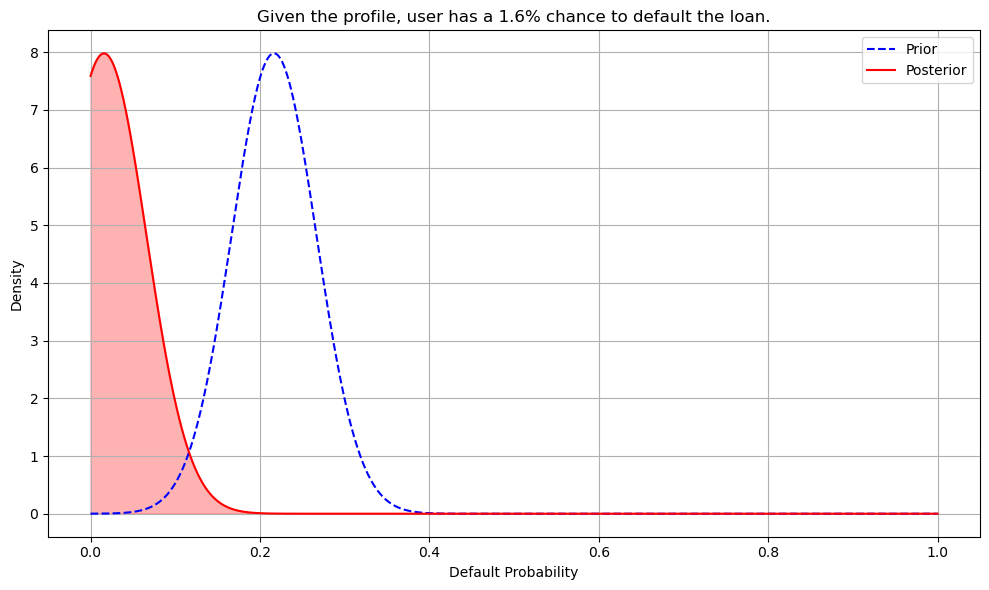


Prediction for case 187:

User profile:
 person_age                                   24
person_income                            200000
person_home_ownership                  MORTGAGE
person_emp_length                           8.0
loan_intent                   DEBTCONSOLIDATION
loan_grade                                    B
loan_amnt                                 20000
loan_int_rate                               NaN
loan_status                                   0
loan_percent_income                         0.1
cb_person_default_on_file                     N
cb_person_cred_hist_length                    3
Name: 187, dtype: object


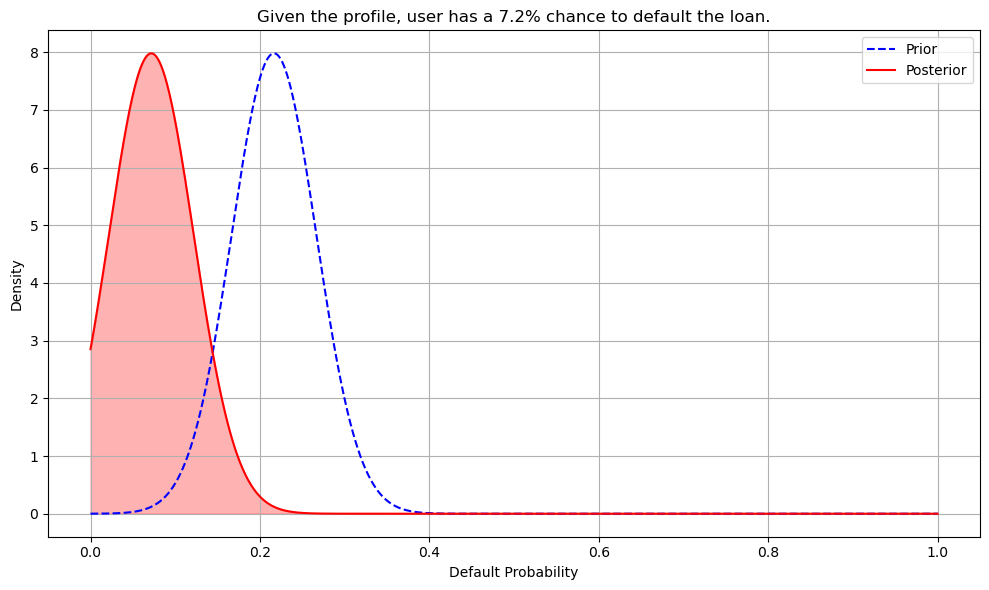


Prediction for case 188:

User profile:
 person_age                                   24
person_income                             60000
person_home_ownership                      RENT
person_emp_length                           2.0
loan_intent                   DEBTCONSOLIDATION
loan_grade                                    E
loan_amnt                                 25000
loan_int_rate                               NaN
loan_status                                   1
loan_percent_income                        0.42
cb_person_default_on_file                     Y
cb_person_cred_hist_length                    2
Name: 188, dtype: object


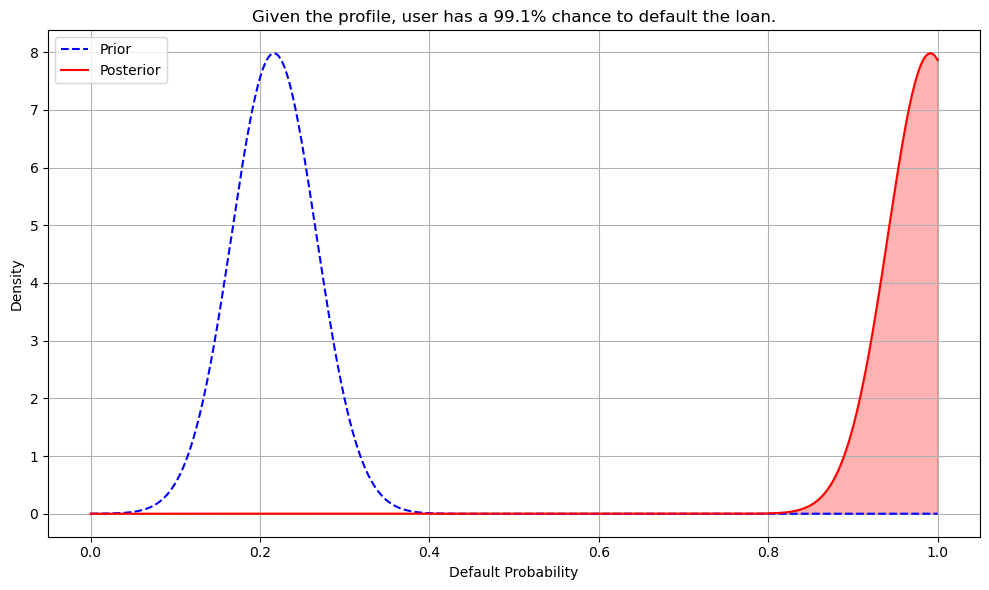


Prediction for case 189:

User profile:
 person_age                                 21
person_income                           14400
person_home_ownership                     OWN
person_emp_length                         0.0
loan_intent                   HOMEIMPROVEMENT
loan_grade                                  B
loan_amnt                                3000
loan_int_rate                             NaN
loan_status                                 1
loan_percent_income                      0.21
cb_person_default_on_file                   N
cb_person_cred_hist_length                  4
Name: 189, dtype: object


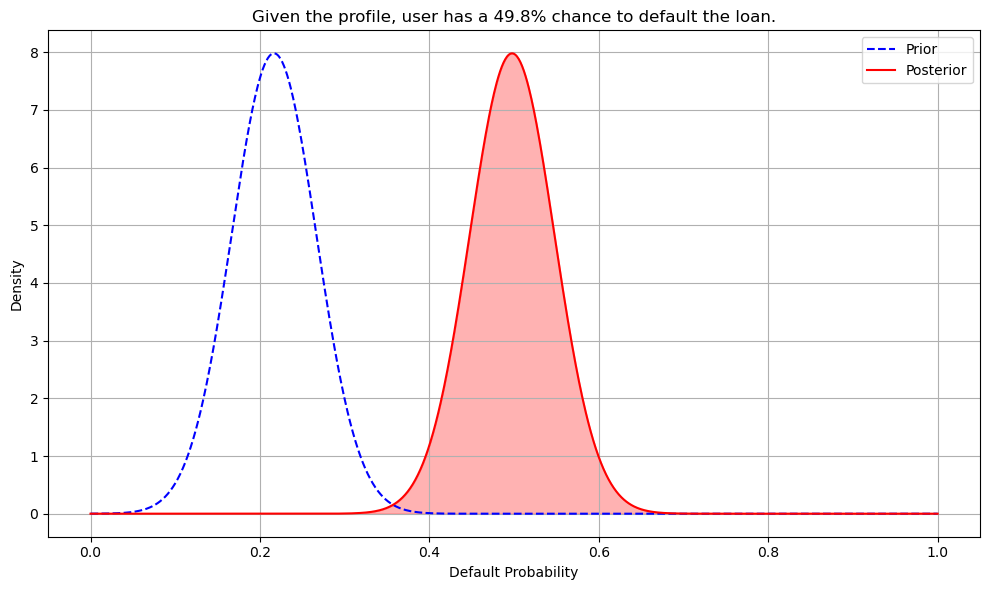


Prediction for case 209:

User profile:
 person_age                         24
person_income                  192000
person_home_ownership            RENT
person_emp_length                 0.0
loan_intent                   MEDICAL
loan_grade                          C
loan_amnt                       22000
loan_int_rate                     NaN
loan_status                         0
loan_percent_income              0.11
cb_person_default_on_file           Y
cb_person_cred_hist_length          2
Name: 209, dtype: object


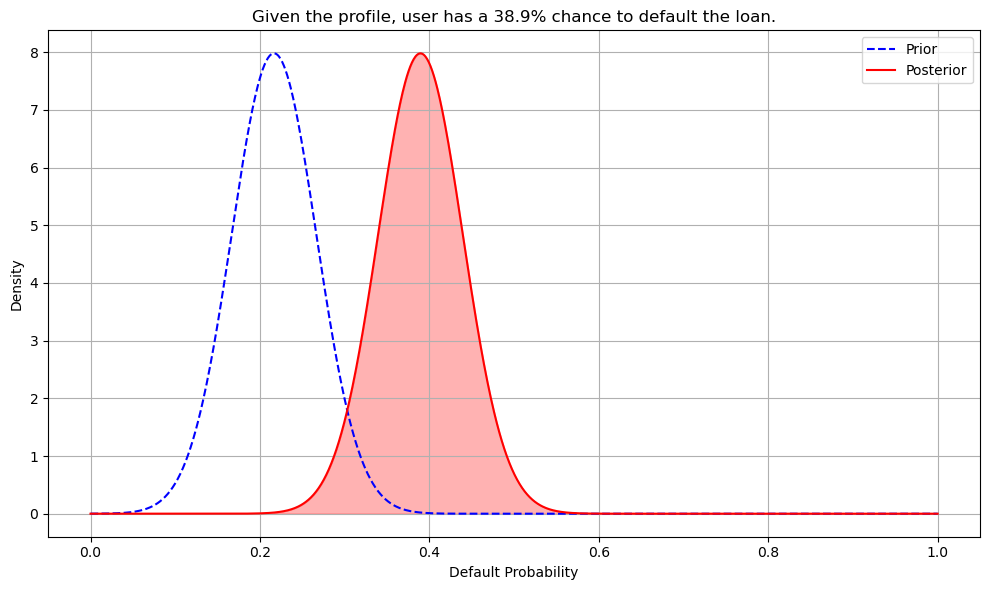


Prediction for case 212:

User profile:
 person_age                          26
person_income                   190300
person_home_ownership         MORTGAGE
person_emp_length                  5.0
loan_intent                   PERSONAL
loan_grade                           A
loan_amnt                        15000
loan_int_rate                      NaN
loan_status                          0
loan_percent_income               0.08
cb_person_default_on_file            N
cb_person_cred_hist_length           3
Name: 212, dtype: object


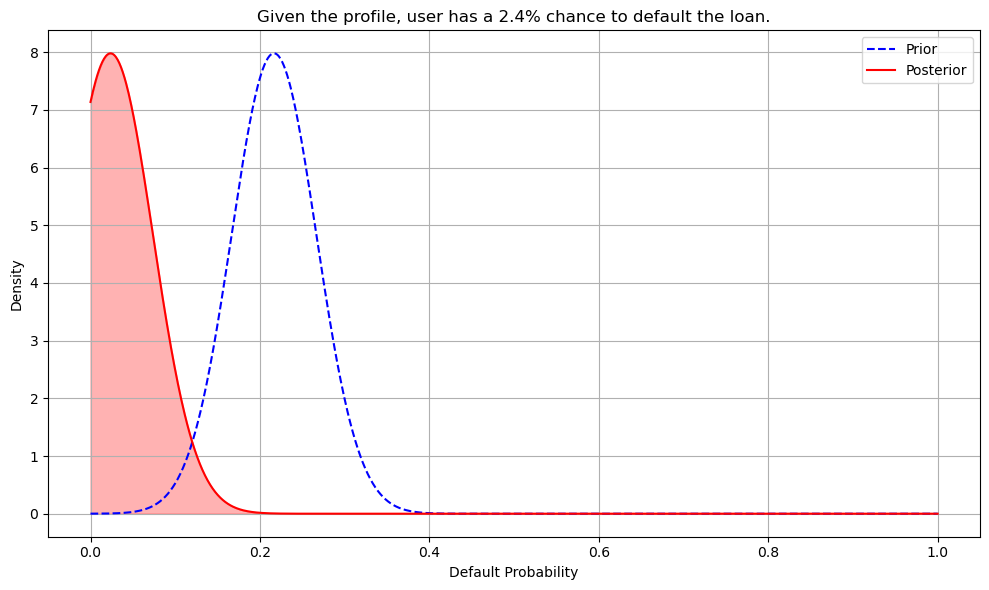


Prediction for case 213:

User profile:
 person_age                          22
person_income                   190000
person_home_ownership         MORTGAGE
person_emp_length                  3.0
loan_intent                    VENTURE
loan_grade                           C
loan_amnt                        10000
loan_int_rate                      NaN
loan_status                          0
loan_percent_income               0.05
cb_person_default_on_file            N
cb_person_cred_hist_length           3
Name: 213, dtype: object


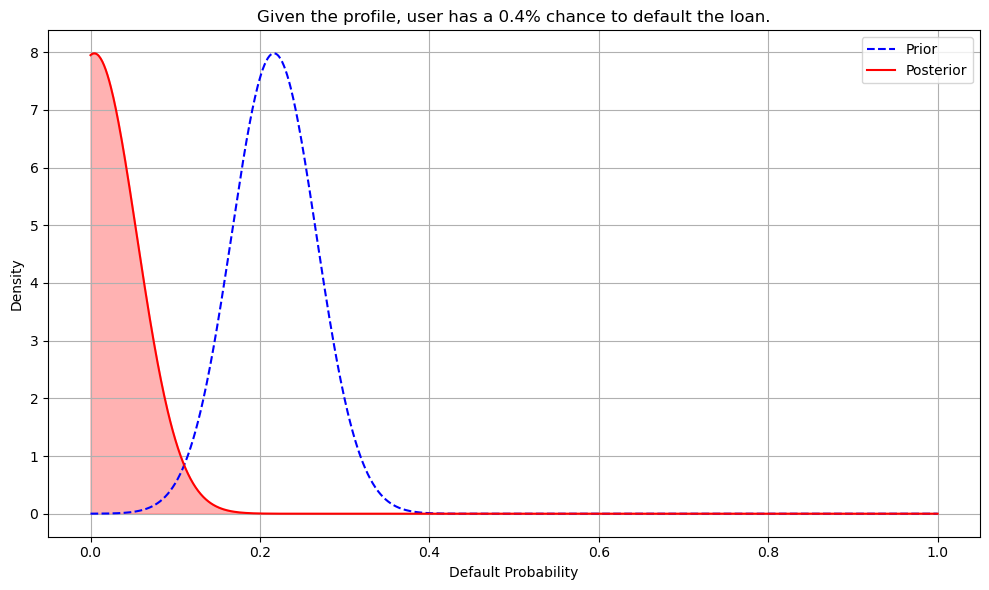


Prediction for case 218:

User profile:
 person_age                                   23
person_income                             78000
person_home_ownership                      RENT
person_emp_length                           7.0
loan_intent                   DEBTCONSOLIDATION
loan_grade                                    C
loan_amnt                                 25000
loan_int_rate                               NaN
loan_status                                   1
loan_percent_income                        0.32
cb_person_default_on_file                     Y
cb_person_cred_hist_length                    2
Name: 218, dtype: object


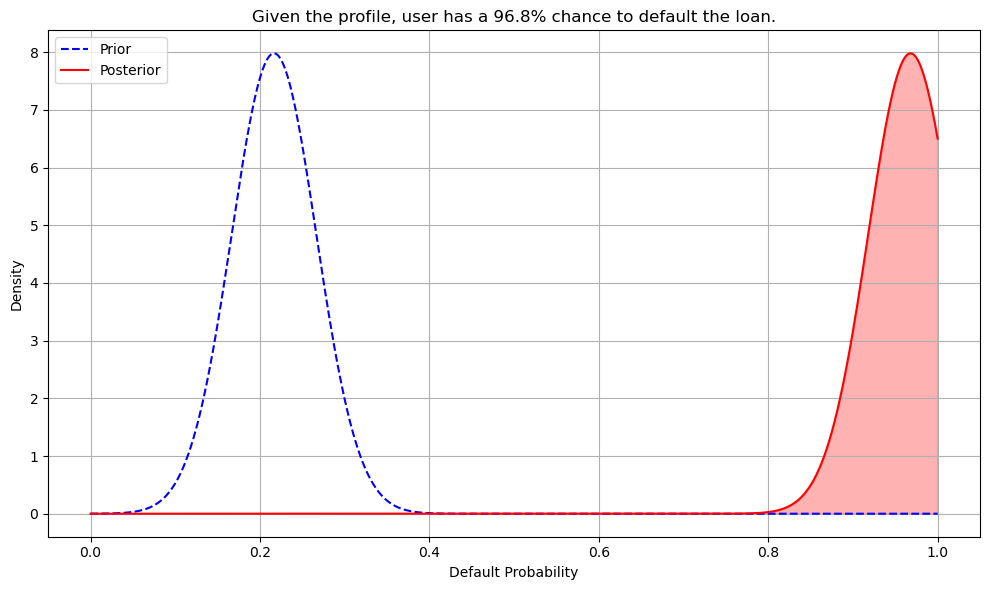


Prediction for case 222:

User profile:
 person_age                           24
person_income                    185000
person_home_ownership          MORTGAGE
person_emp_length                   NaN
loan_intent                   EDUCATION
loan_grade                            B
loan_amnt                         35000
loan_int_rate                     12.42
loan_status                           0
loan_percent_income                0.19
cb_person_default_on_file             N
cb_person_cred_hist_length            2
Name: 222, dtype: object


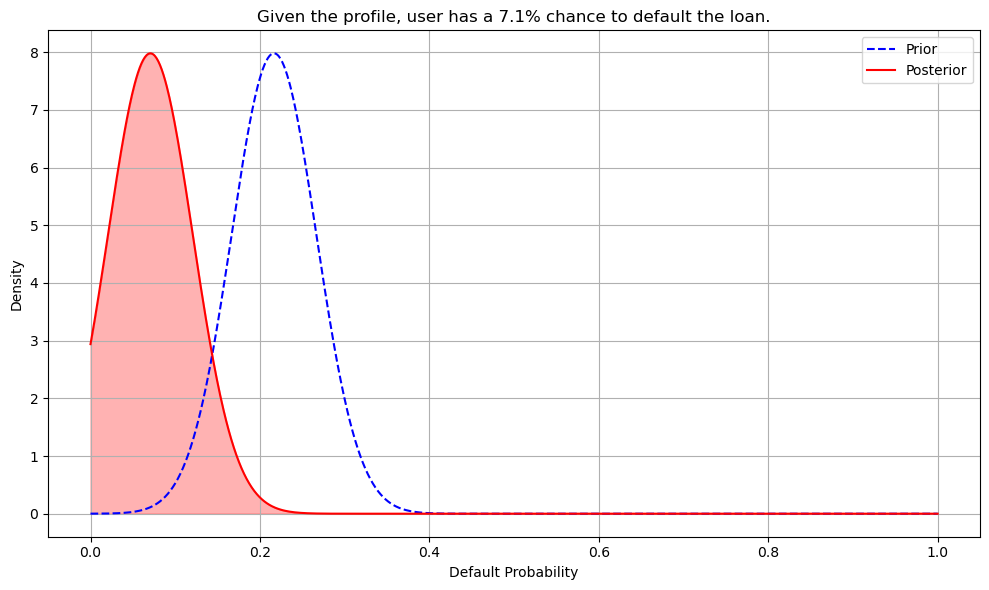


Prediction for case 229:

User profile:
 person_age                          21
person_income                    14400
person_home_ownership         MORTGAGE
person_emp_length                  0.0
loan_intent                    MEDICAL
loan_grade                           C
loan_amnt                         1500
loan_int_rate                      NaN
loan_status                          0
loan_percent_income                0.1
cb_person_default_on_file            N
cb_person_cred_hist_length           4
Name: 229, dtype: object


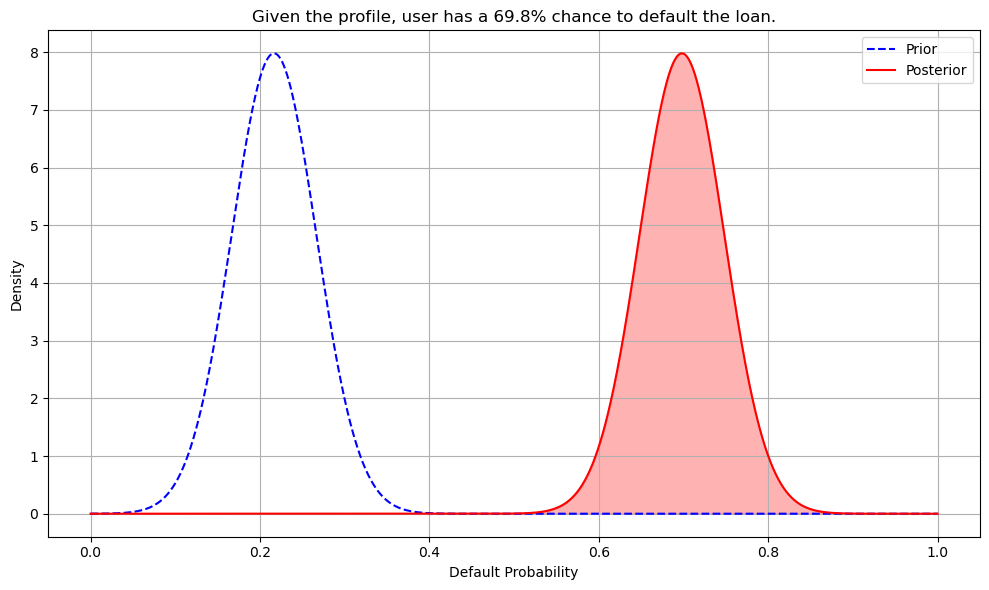


Prediction for case 238:

User profile:
 person_age                           22
person_income                    183000
person_home_ownership          MORTGAGE
person_emp_length                   3.0
loan_intent                   EDUCATION
loan_grade                            A
loan_amnt                          1000
loan_int_rate                       NaN
loan_status                           0
loan_percent_income                0.01
cb_person_default_on_file             N
cb_person_cred_hist_length            2
Name: 238, dtype: object


KeyboardInterrupt: 

In [28]:
def run_bayesian_predictions_on_missing(df_missing, df_cleaned, feature_columns):
    feature_probs = calculate_feature_probs(df_cleaned, feature_columns)

    for idx, row in df_missing.iterrows():
        case = row[feature_columns].dropna().to_dict()  # Skip missing values
        print(f"\nPrediction for case {idx}:")
        print(f"\nUser profile:\n {row}")
        bayesian_predict(case, df_cleaned, feature_probs)

# List of features
feature_columns = [
    'person_age', 'person_income', 'person_emp_length', 'loan_amnt',
    'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
    'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_cred_hist_length'
]
df_missing = filter_missing_values(df)
run_bayesian_predictions_on_missing(df_missing, df_cleaned, feature_columns)